In [13]:
import pandas as pd
import pyranges as pr
import sys
import os
from Bio import SearchIO
import yaml
from snakemake.io import expand
import pdb
import swan_vis as swan

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *
from scripts.mane_utils import *

In [14]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [15]:
ab = '../'+expand(config['data']['ab'], species='human')[0]
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
read_annot = '../'+expand(config['data']['read_annot'], species='human')[0]
ref_t_metadata = '../'+expand(config['ref']['t_info'], species='human')[0]
ref_g_metadata = '../'+expand(config['ref']['g_info'], species='human')[0]
t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
swan_file = '../'+expand(config['data']['sg'], species='human')[0]
cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]
cerb_t_metadata = '../'+expand(config['data']['t_info'], species='human')[0]
major_isos = '../'+expand(config['data']['major_isos'], species='human', obs_col='sample')[0]
orf_fa = '../'+expand(config['data']['p_pred']['orf_fa'], species='human')[0]
pp_bed = '../'+expand(config['data']['p_pred']['cds_bed'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_lib_meta = '../'+expand(config['data']['meta'], species='mouse')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'

In [65]:
df = read_pred(pp_bed)
df = read_orf_fa(orf_fa)

df.head()

,Chromosome,Start,Stop,fields,Strand,CDS_Start,CDS_Stop,gid,tid,gname,pid,t_len_flag,blastp_match,nmd_flag,frame,nmd,full_orf
0,chr1,169794679,169853135,"ENSG00000000460.16;ENSG00000000460[3,10,3];NA;...",+,169795102,169852984,ENSG00000000460.16,"ENSG00000000460[3,10,3]",NA,ENSP00000286031.6,full_length,full_match,prot_ok,F1,False,True
1,chr1,169794989,169853135,"ENSG00000000460.16;ENSG00000000460[1,10,3];NA;...",+,169794991,169852984,ENSG00000000460.16,"ENSG00000000460[1,10,3]",NA,ENSP00000286031.6,5prime_degrade,full_match,prot_ok,F3,False,False
2,chr1,169794989,169853311,"ENSG00000000460.16;ENSG00000000460[1,10,6];NA;...",+,169794991,169852984,ENSG00000000460.16,"ENSG00000000460[1,10,6]",NA,ENSP00000286031.6,5prime_degrade,full_match,prot_ok,F3,False,False
3,chr1,169794989,169854130,"ENSG00000000460.16;ENSG00000000460[1,10,1];NA;...",+,169794991,169852984,ENSG00000000460.16,"ENSG00000000460[1,10,1]",NA,ENSP00000286031.6,5prime_degrade,full_match,prot_ok,F3,False,False
4,chr1,169794679,169853135,"ENSG00000000460.16;ENSG00000000460[3,11,3];NA;...",+,169802641,169852984,ENSG00000000460.16,"ENSG00000000460[3,11,3]",NA,ENSP00000389257.3,full_length,full_match,prot_ok,F2,False,True


In [38]:
iso_df = pd.read_csv(filt_ab, sep='\t')
iso_df, tids = get_tpm_table(iso_df,
                           how='iso',
                           min_tpm=min_tpm,
                           gene_subset=gene_subset)
len(tids)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806


206806

In [40]:
# get tids for each protein pred
df = df.loc[df.tid.isin(tids)]
len(df.index)

206806

In [42]:
ca = cerberus.read(cerberus_h5)

In [55]:
sg = swan.read(swan_file)

Read in graph from ../data/human/swan_graph.p


In [109]:
# get the acta1 transcripts from heart
def get_isos(ca, filt_ab, gene, sample, species):
    df = pd.read_csv(filt_ab, sep='\t')
    df = get_det_table(df,
                   groupby='sample',
                   how='iso',
                   min_tpm=1,
                   gene_subset='polya',
                   species=species)
    df = df.loc[sample]
    df = df.to_frame()
    df = df.loc[df[sample]==True]
    gid = ca.triplets.loc[ca.triplets.gname==gene, 'gid'].values[0]
    df.reset_index(inplace=True)
    df['gid'] = df['index'].str.split('[', expand=True)[0]
    df = df.loc[df.gid == gid]
    tids = df['index'].tolist()
    return tids

def get_tpm_df(sg, tids, obs_col, obs_condition):
    # get tpm df
    tpm_df = swan.calc_tpm(sg.adata, obs_col=obs_col).sparse.to_dense()
    tpm_df = tpm_df.transpose()
    tpm_df = tpm_df.loc[tids, obs_condition].to_frame()
    return tpm_df


In [110]:
obs_condition = 'heart'
tids = get_isos(ca, filt_ab, 'ACTA1', obs_condition, 'human')
tpm_df = get_tpm_df(sg, tids, obs_col, obs_condition)
tpm_df = tpm_df.sort_values(by=obs_condition, ascending=False)


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2069: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2068: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806
Found 50 total samples


In [112]:
tpm_df.head()
tids = tpm_df.index.tolist()

In [114]:
# df.set_index('tid', inplace=True)
df.loc[tids][['CDS_Start', 'CDS_Stop', 'frame', 'nmd']]

In [50]:
a_df = df.loc[df.tid.isin(tids)]
a_df[['tid', 'CDS_Start', 'CDS_Stop', 'frame', 'nmd']].sort_values(['CDS_Start', 'frame'])


,tid,CDS_Start,CDS_Stop,frame,nmd
16913,"ENSG00000143632[1,8,1]",229431501,229433115,F1,False
16920,"ENSG00000143632[1,7,1]",229431501,229433115,F1,False
16922,"ENSG00000143632[1,19,1]",229431501,229433115,F1,False
16907,"ENSG00000143632[1,6,1]",229431501,229433115,F2,False
16908,"ENSG00000143632[1,2,1]",229431501,229432874,F2,False
16910,"ENSG00000143632[1,3,1]",229431501,229433115,F2,False
16921,"ENSG00000143632[1,18,1]",229431501,229433115,F2,False
16924,"ENSG00000143632[1,1,1]",229431501,229433115,F2,False
16909,"ENSG00000143632[1,5,1]",229431501,229432874,F3,False
16915,"ENSG00000143632[1,16,1]",229431501,229433115,F3,False


## Okay, what are the actual ORF sequences for all these ACTA transcripts?

In [106]:
df = read_orf_fa(orf_fa)
# df.set_index('tid', inplace=True)

In [116]:
len(tids)
tids

['ENSG00000143632[1,1,1]',
 'ENSG00000143632[1,12,1]',
 'ENSG00000143632[1,2,1]',
 'ENSG00000143632[1,8,1]',
 'ENSG00000143632[1,17,1]',
 'ENSG00000143632[1,10,1]',
 'ENSG00000143632[1,9,1]',
 'ENSG00000143632[1,3,1]',
 'ENSG00000143632[1,13,1]',
 'ENSG00000143632[1,18,1]',
 'ENSG00000143632[1,15,1]',
 'ENSG00000143632[1,11,1]',
 'ENSG00000143632[1,16,1]',
 'ENSG00000143632[1,19,1]',
 'ENSG00000143632[1,7,1]',
 'ENSG00000143632[1,6,1]',
 'ENSG00000143632[1,14,1]',
 'ENSG00000143632[1,5,1]']

In [117]:
# df.loc[tids][['seq', 'len']]
temp = df.sort_values(by='len', ascending=False).drop_duplicates(subset='tid', keep='first')
temp.set_index('tid', inplace=True)
temp.loc[tids][['seq', 'len']]

,seq,len
tid,,
"ENSG00000143632[1,1,1]",MCDEDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,377
"ENSG00000143632[1,12,1]",MCDEDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,221
"ENSG00000143632[1,2,1]",MVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIITNWDDMEKIWHHT...,332
"ENSG00000143632[1,8,1]",MCDEDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,377
"ENSG00000143632[1,17,1]",MCDEDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,377
"ENSG00000143632[1,10,1]",MCDEDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,209
"ENSG00000143632[1,9,1]",MVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIITNWDDMEKIWHHT...,332
"ENSG00000143632[1,3,1]",MCDEDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,351
"ENSG00000143632[1,13,1]",MCDEDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,285


In [123]:
mane_orf = temp.loc['ENSG00000143632[1,1,1]', 'seq']
temp['mane_orf'] = temp.seq==mane_orf

In [126]:
temp = temp.merge(a_df, how='left', left_index=True, right_on='tid')

In [129]:
temp.set_index('tid', inplace=True)

In [130]:
temp.loc[tids][['seq', 'len', 'mane_orf', 'CDS_Start', 'CDS_Stop', 'frame', 'nmd']]

,seq,len,mane_orf,CDS_Start,CDS_Stop,frame,nmd
tid,,,,,,,
"ENSG00000143632[1,1,1]",MCDEDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,377,True,229431501.0,229433115.0,F2,False
"ENSG00000143632[1,12,1]",MCDEDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,221,False,229432222.0,229433115.0,F2,True
"ENSG00000143632[1,2,1]",MVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIITNWDDMEKIWHHT...,332,False,229431501.0,229432874.0,F2,False
"ENSG00000143632[1,8,1]",MCDEDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,377,True,229431501.0,229433115.0,F1,False
"ENSG00000143632[1,17,1]",MCDEDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,377,True,229431501.0,229433115.0,F3,False
"ENSG00000143632[1,10,1]",MCDEDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,209,False,229432382.0,229433115.0,F2,True
"ENSG00000143632[1,9,1]",MVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIITNWDDMEKIWHHT...,332,False,229431501.0,229432874.0,F3,False
"ENSG00000143632[1,3,1]",MCDEDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,351,False,229431501.0,229433115.0,F2,False
"ENSG00000143632[1,13,1]",MCDEDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...,285,False,229431850.0,229433115.0,F2,True


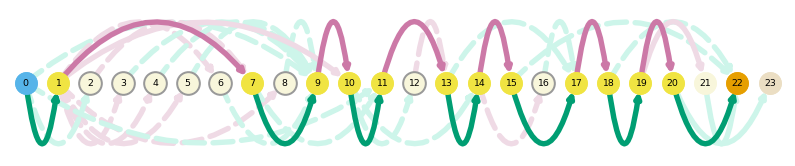

In [137]:
# plot some isoforms using swan
tid = 'ENSG00000143632[1,1,1]' 
sg.plot_transcript_path(tid, indicate_novel=True)

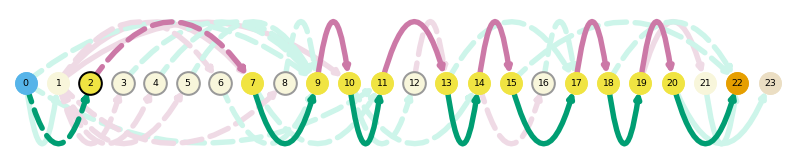

In [138]:
tid = 'ENSG00000143632[1,7,1]'
sg.plot_transcript_path(tid, indicate_novel=True)

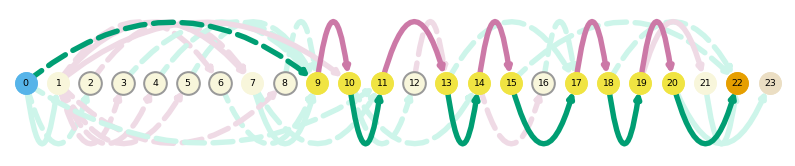

In [139]:
tid = 'ENSG00000143632[1,6,1]'
sg.plot_transcript_path(tid, indicate_novel=True)

## What % of novel IC transcripts are predicted to be NMD?

In [143]:
df = read_pred(pp_bed)
iso_df = pd.read_csv(filt_ab, sep='\t')
iso_df, tids = get_tpm_table(iso_df,
                           how='iso',
                           min_tpm=min_tpm,
                           gene_subset=gene_subset)
# get tids for each protein pred
df = df.loc[df.tid.isin(tids)]
len(df.index)

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2069: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2068: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806


206806

In [146]:
for feat in ['tss', 'ic', 'tes']:
    df = add_feat(df, col='tid', kind=feat)
    feat_df = get_ca_table(cerberus_h5, feat)
    feat_df = feat_df[['Name', 'novelty']]
    feat_df.rename({'novelty': '{}_novelty'.format(feat),
                    'Name': feat}, axis=1, inplace=True)
    df = df.merge(feat_df, how='left', on=feat)

In [148]:
df.head()

,Chromosome,Start,Stop,fields,Strand,CDS_Start,CDS_Stop,gid,tid,gname,...,nmd_flag,frame,nmd,full_orf,tss,tss_novelty,ic,ic_novelty,tes,tes_novelty
0,chr1,169794679,169853135,"ENSG00000000460.16;ENSG00000000460[3,10,3];NA;...",+,169795102,169852984,ENSG00000000460.16,"ENSG00000000460[3,10,3]",NA,...,prot_ok,F1,False,True,ENSG00000000460_3,Known,ENSG00000000460_10,NIC,ENSG00000000460_3,Known
1,chr1,169794989,169853135,"ENSG00000000460.16;ENSG00000000460[1,10,3];NA;...",+,169794991,169852984,ENSG00000000460.16,"ENSG00000000460[1,10,3]",NA,...,prot_ok,F3,False,False,ENSG00000000460_1,Known,ENSG00000000460_10,NIC,ENSG00000000460_3,Known
2,chr1,169794989,169853311,"ENSG00000000460.16;ENSG00000000460[1,10,6];NA;...",+,169794991,169852984,ENSG00000000460.16,"ENSG00000000460[1,10,6]",NA,...,prot_ok,F3,False,False,ENSG00000000460_1,Known,ENSG00000000460_10,NIC,ENSG00000000460_6,Novel
3,chr1,169794989,169854130,"ENSG00000000460.16;ENSG00000000460[1,10,1];NA;...",+,169794991,169852984,ENSG00000000460.16,"ENSG00000000460[1,10,1]",NA,...,prot_ok,F3,False,False,ENSG00000000460_1,Known,ENSG00000000460_10,NIC,ENSG00000000460_1,Known
4,chr1,169794679,169853135,"ENSG00000000460.16;ENSG00000000460[3,11,3];NA;...",+,169802641,169852984,ENSG00000000460.16,"ENSG00000000460[3,11,3]",NA,...,prot_ok,F2,False,True,ENSG00000000460_3,Known,ENSG00000000460_11,NIC,ENSG00000000460_3,Known


In [149]:
n = len(df.loc[df.ic_novelty != 'Known'].index)
n_num = len(df.loc[(df.ic_novelty != 'Known')&(df.nmd == True)].index)
print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) of transcripts with novel ICs are predicted NMD')

27.35% (20913/76469) of transcripts with novel ICs are predicted NMD


In [151]:
# number of novel transcripts (including 5' / 3' end)
refs = ['v40', 'v29']
ref = ca.t_map.loc[ca.t_map.source.isin(refs)]
ref_tids = ref.transcript_id.unique().tolist()

n = len(df.loc[df.tid.isin(ref_tids)].index)
n_num = len(df.loc[(df.tid.isin(ref_tids))&(df.nmd==True)].index)
print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) of novel transcripts are predicted NMD')

19.89% (16813/84521) of novel transcripts are predicted NMD


## How often does a non-MANE predominant isoform have the same ORF as the MANE isoform?

In [34]:
sg = swan.read(swan_file)
ca = cerberus.read(cerberus_h5)
mp_df = get_mp_df_table(sg, ca, 
                       ref_t_metadata,
                       ref_g_metadata,
                       'dataset',
                       min_tpm,
                       feat='triplet')

orf_df = read_orf_fa(orf_fa)
pp_df = read_pred(pp_bed)

Read in graph from ../data/human/swan_graph.p


In [44]:
temp = mp_df.merge(orf_df[['tid', 'seq', 'len']],
                    how='left',
                    left_on='tid_princ',
                    right_on='tid',
                    suffixes=('', '_orf_princ'))
temp = temp.merge(orf_df[['tid', 'seq', 'len']],
                    how='left',
                    left_on='tid_mane',
                    right_on='tid',
                    suffixes=('', '_orf_mane'))

In [45]:
temp = temp.merge(pp_df[['tid', 'nmd']],
            how='left', 
            left_on='tid_princ',
            right_on='tid',
            suffixes=('', '_pp_princ'))
temp = temp.merge(pp_df[['tid', 'nmd']],
            how='left', 
            left_on='tid_mane',
            right_on='tid',
            suffixes=('', '_pp_mane'))

In [47]:
temp['triplet_princ_orf_is_mane'] = temp['seq'] == temp['seq_orf_mane']

In [49]:
temp.columns

Index(['tid_princ', 'dataset', 'triplet_tpm_princ', 'triplet_pi_princ', 'gid',
       'gname', 'triplet_rank_princ', 'tid_mane', 'triplet_tpm_mane',
       'triplet_pi_mane', 'triplet_rank_mane', 'tid_sec', 'triplet_tpm_sec',
       'triplet_pi_sec', 'triplet_rank_sec', 'triplet_princ_is_mane',
       'triplet_sec_is_mane', 'tid', 'seq', 'len', 'tid_orf_mane',
       'seq_orf_mane', 'len_orf_mane', 'tid_pp_princ', 'nmd', 'tid_pp_mane',
       'nmd_pp_mane', 'triplet_princ_orf_is_mane'],
      dtype='object')

In [51]:
n = len(temp.loc[temp.triplet_princ_is_mane==False, 'tid_princ'].unique().tolist())
n_num = len(temp.loc[(temp.triplet_princ_is_mane==False)&(temp.triplet_princ_orf_is_mane==True), 'tid_princ'].unique().tolist())
print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) of non-MANE predominant transcripts have the same ORF as MANE')


37.47% (20114/53686) of non-MANE predominant transcripts have the same ORF as MANE


## How often is non-MANE predominant transcript NMD?

In [52]:
n = len(temp.loc[temp.triplet_princ_is_mane==False, 'tid_princ'].unique().tolist())
n_num = len(temp.loc[(temp.triplet_princ_is_mane==False)&(temp.nmd==True), 'tid_princ'].unique().tolist())
print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) of non-MANE predominant transcripts are predicted NMD')


15.25% (8185/53686) of non-MANE predominant transcripts are predicted NMD
